In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = Path('/home/jupyter/.fastai/data/camvid/')

In [4]:
path_img = path/'images'
path_lbl = path/'labels'

In [5]:
fnames = get_image_files(path_img)

In [6]:
lbl_names = get_image_files(path_lbl)

In [7]:
#open_image(fnames[10]).show(figsize=(10, 10))

In [8]:
get_y_fn = lambda x_fn: path_lbl/f'{x_fn.stem}_P{x_fn.suffix}'

In [9]:
mask = open_mask(get_y_fn(fnames[10]))

In [10]:
#mask.show(figsize=(10, 10), )

In [11]:
#mask.data

In [12]:
mask.shape

torch.Size([1, 720, 960])

In [13]:
src_size = np.array(mask.shape[1:])

In [14]:
src_size

array([720, 960])

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [16]:
size = src_size // 2
bs = 4

In [17]:
src = (SegmentationItemList
       .from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [19]:
data = (src.transform(tfms=get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [20]:
data

ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None

In [18]:
name2id = {v: i for i, v in enumerate(codes)}
void_code = name2id['Void']

In [19]:
void_code

30

In [20]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [21]:
metrics = acc_camvid

In [22]:
wd = 1e-2

In [26]:
learn = unet_learner(data, models.resnet34, wd=wd, metrics=metrics)

In [27]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


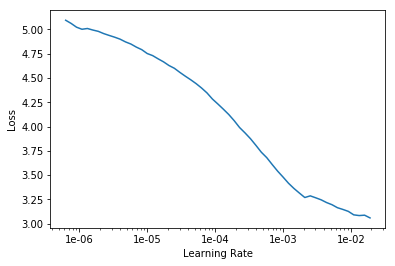

In [28]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(max_lr=slice(3e-3), cyc_len=10, pct_start=.9)

epoch,train_loss,valid_loss,acc_camvid
1,0.945145,0.803615,0.817163
2,0.694547,0.604910,0.834254
3,0.655261,0.582441,0.832382
4,0.617719,0.525533,0.866493
5,0.615101,0.558629,0.879383
6,0.584926,0.491263,0.880342
7,0.566780,0.469465,0.870323
8,0.516050,0.430621,0.883362
9,0.509175,0.398044,0.894437
10,0.421742,0.326014,0.903318


In [32]:
learn.save('stage-1')

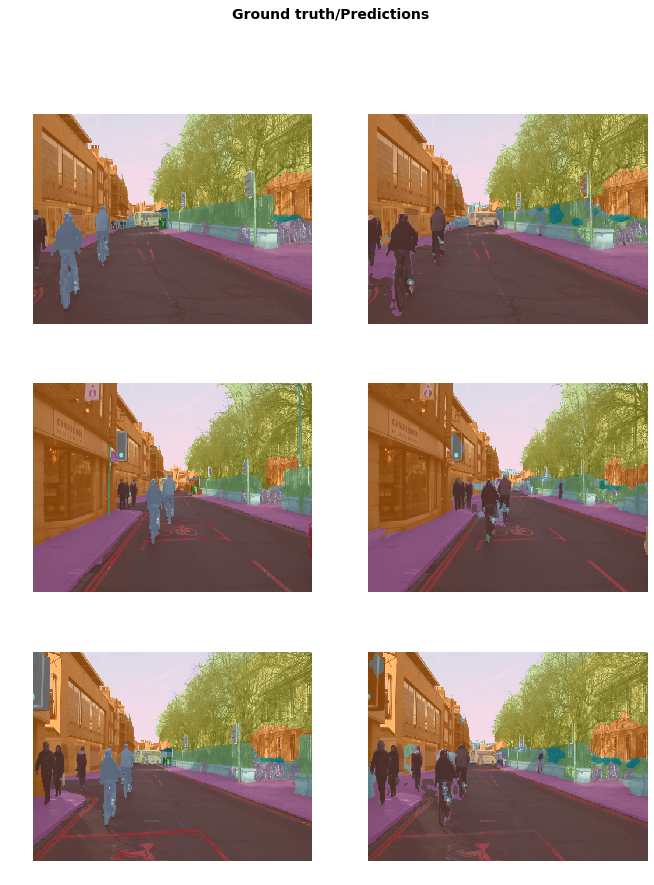

In [34]:
learn.show_results(rows=3, figsize=(11, 14))

In [35]:
learn.unfreeze()

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


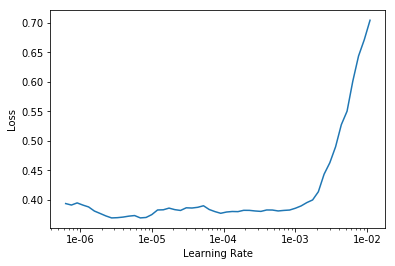

In [37]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(cyc_len=12, max_lr=slice(1e-6, 3e-3), pct_start=.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.269114,0.274981,0.923292
2,0.260689,0.279695,0.921240
3,0.268026,0.280837,0.919865
4,0.277758,0.303359,0.918965
5,0.290808,0.291461,0.919686
6,0.293189,0.344578,0.915722
7,0.302383,0.363598,0.901884
8,0.312891,0.306708,0.916051
9,0.334811,0.368181,0.904389
10,0.316346,0.351239,0.907893


In [43]:
learn.save('stage-2')

In [23]:
size = src_size

In [24]:
bs = 2

In [25]:
data = (src.transform(tfms=get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [26]:
learn = unet_learner(data=data, arch=models.resnet34, metrics=metrics, wd=wd)

In [27]:
learn.load('stage-2');

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 759.38 MiB (GPU 0; 7.43 GiB total capacity; 6.66 GiB already allocated; 190.94 MiB free; 20.06 MiB cached)